In [1]:
# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model


Training model for spectrogram type: stft
Epoch 1/50
53/53 [==============================] - 215s 4s/step - loss: 0.6627 - accuracy: 0.6357 - val_loss: 0.5501 - val_accuracy: 0.7667
Epoch 2/50
53/53 [==============================] - 211s 4s/step - loss: 0.4839 - accuracy: 0.7917 - val_loss: 0.5435 - val_accuracy: 0.7714
Epoch 3/50
53/53 [==============================] - 201s 4s/step - loss: 0.4398 - accuracy: 0.8024 - val_loss: 0.4802 - val_accuracy: 0.7857
Epoch 4/50
53/53 [==============================] - 201s 4s/step - loss: 0.3762 - accuracy: 0.8226 - val_loss: 0.4682 - val_accuracy: 0.7905
Epoch 5/50
53/53 [==============================] - 159s 3s/step - loss: 0.3532 - accuracy: 0.8357 - val_loss: 0.4869 - val_accuracy: 0.7810
Epoch 6/50
53/53 [==============================] - 210s 4s/step - loss: 0.2980 - accuracy: 0.8726 - val_loss: 0.4838 - val_accuracy: 0.7857
Epoch 7/50
53/53 [==============================] - 209s 4s/step - loss: 0.2457 - accuracy: 0.8964 - val_loss: 0

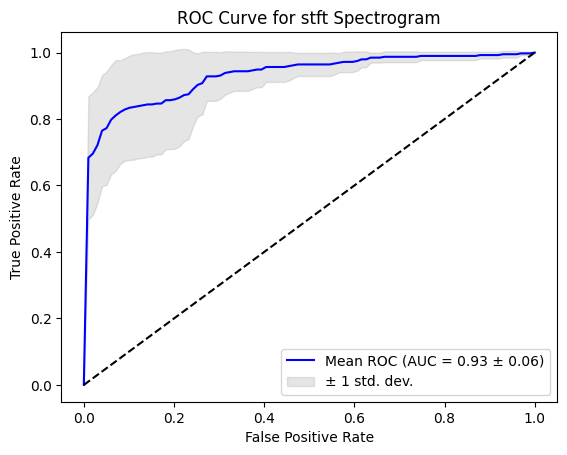


Mean and Std Dev of Performance Metrics for Spectrogram stft:
Fold                    3.000000
Accuracy               88.476190
F1 Score                0.880899
Precision               0.888402
Recall                  0.884762
Specificity             0.952857
Kappa                   0.742053
ROC AUC                 0.932598
Training Time (s)    1561.740220
Testing Time (s)       13.581265
dtype: float64
Fold                   1.581139
Accuracy               7.418491
F1 Score               0.078151
Precision              0.072424
Recall                 0.074185
Specificity            0.031956
Kappa                  0.170982
ROC AUC                0.067127
Training Time (s)    149.921886
Testing Time (s)       0.763014
dtype: float64


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mfcc
Epoch 1/50
53/53 [==============================] - 242s 4s/step - loss: 0.7095 - accuracy: 0.6226 - val_loss: 0.6690 - val_accuracy: 0.6286
Epoch 2/50
53/53 [==============================] - 233s 4s/step - loss: 0.6675 - accuracy: 0.6250 - val_loss: 0.6639 - val_accuracy: 0.6286
Epoch 3/50
53/53 [==============================] - 230s 4s/step - loss: 0.6629 - accuracy: 0.6250 - val_loss: 0.6650 - val_accuracy: 0.6286
Epoch 4/50
53/53 [==============================] - 231s 4s/step - loss: 0.6636 - accuracy: 0.6119 - val_loss: 0.6673 - val_accuracy: 0.6048
Epoch 5/50
53/53 [==============================] - 230s 4s/step - loss: 0.6614 - accuracy: 0.6238 - val_loss: 0.6604 - val_accuracy: 0.6286
Epoch 6/50
53/53 [==============================] - 228s 4s/step - loss: 0.6610 - accuracy: 0.6250 - val_loss: 0.6642 - val_accuracy: 0.6286
Epoch 7/50
53/53 [==============================] - 229s 4s/step - loss: 0.6599 - accuracy: 0.6214 - val_loss: 0


Mean and Std Dev of Performance Metrics for Spectrogram mfcc:
Fold                    3.000000
Accuracy               73.047619
F1 Score                0.710703
Precision               0.736535
Recall                  0.730476
Specificity             0.859762
Kappa                   0.384863
ROC AUC                 0.767206
Training Time (s)    2192.189573
Testing Time (s)       13.223780
dtype: float64
Fold                    1.581139
Accuracy                4.839838
F1 Score                0.077016
Precision               0.039646
Recall                  0.048398
Specificity             0.073466
Kappa                   0.154148
ROC AUC                 0.086885
Training Time (s)    1657.461321
Testing Time (s)        4.232256
dtype: float64


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: chroma
Epoch 1/50
53/53 [==============================] - 182s 3s/step - loss: 0.6443 - accuracy: 0.6607 - val_loss: 0.5873 - val_accuracy: 0.7238
Epoch 2/50
53/53 [==============================] - 182s 3s/step - loss: 0.4879 - accuracy: 0.7702 - val_loss: 0.5793 - val_accuracy: 0.7048
Epoch 3/50
53/53 [==============================] - 180s 3s/step - loss: 0.4086 - accuracy: 0.8155 - val_loss: 0.5838 - val_accuracy: 0.7143
Epoch 4/50
53/53 [==============================] - 179s 3s/step - loss: 0.3325 - accuracy: 0.8702 - val_loss: 0.6217 - val_accuracy: 0.7333
Epoch 5/50
53/53 [==============================] - 179s 3s/step - loss: 0.2243 - accuracy: 0.9262 - val_loss: 0.6994 - val_accuracy: 0.6905
Epoch 6/50
53/53 [==============================] - 181s 3s/step - loss: 0.1234 - accuracy: 0.9714 - val_loss: 0.8116 - val_accuracy: 0.6810
Epoch 7/50
7/7 [==============================] - 11s 2s/step
Fold 1 Results: Accuracy=70.48%, F1=0.70, Precis


Mean and Std Dev of Performance Metrics for Spectrogram chroma:
Fold                    3.000000
Accuracy               85.809524
F1 Score                0.852490
Precision               0.861434
Recall                  0.858095
Specificity             0.936225
Kappa                   0.680931
ROC AUC                 0.899580
Training Time (s)    1417.639025
Testing Time (s)        9.753844
dtype: float64
Fold                   1.581139
Accuracy              11.420632
F1 Score               0.119506
Precision              0.113610
Recall                 0.114206
Specificity            0.072739
Kappa                  0.259740
ROC AUC                0.114490
Training Time (s)    709.105267
Testing Time (s)       1.229107
dtype: float64


Training model for spectrogram type: cqt
Epoch 1/50
53/53 [==============================] - 203s 4s/step - loss: 0.6519 - accuracy: 0.6500 - val_loss: 0.5389 - val_accuracy: 0.7524
Epoch 2/50
53/53 [==============================] - 234s 4s/step - loss: 0.4589 - accuracy: 0.7976 - val_loss: 0.4740 - val_accuracy: 0.8048
Epoch 3/50
53/53 [==============================] - 235s 4s/step - loss: 0.3699 - accuracy: 0.8321 - val_loss: 0.5231 - val_accuracy: 0.7762
Epoch 4/50
53/53 [==============================] - 234s 4s/step - loss: 0.3177 - accuracy: 0.8560 - val_loss: 0.5663 - val_accuracy: 0.7810
Epoch 5/50
53/53 [==============================] - 232s 4s/step - loss: 0.2657 - accuracy: 0.8976 - val_loss: 0.5439 - val_accuracy: 0.7333
Epoch 6/50
53/53 [==============================] - 235s 4s/step - loss: 0.2049 - accuracy: 0.9298 - val_loss: 0.5273 - val_accuracy: 0.7619
Epoch 7/50
7/7 [==============================] - 17s 2s/step
Fold 1 Results: Accuracy=80.48%, F1=0.79, Precision

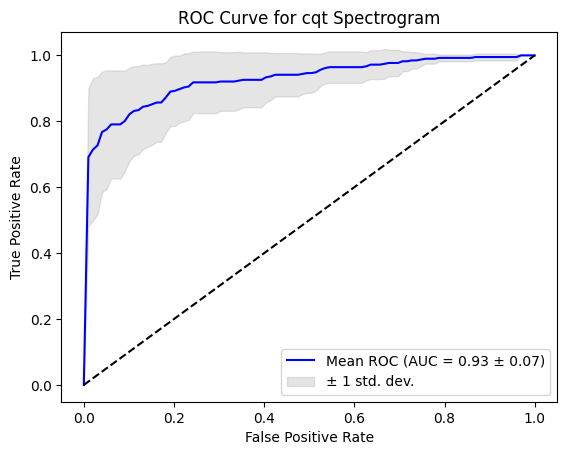


Mean and Std Dev of Performance Metrics for Spectrogram cqt:
Fold                    3.000000
Accuracy               88.571429
F1 Score                0.881381
Precision               0.890499
Recall                  0.885714
Specificity             0.952822
Kappa                   0.743539
ROC AUC                 0.928489
Training Time (s)    1671.634109
Testing Time (s)       13.556022
dtype: float64
Fold                   1.581139
Accuracy               8.095238
F1 Score               0.085782
Precision              0.076243
Recall                 0.080952
Specificity            0.042958
Kappa                  0.186689
ROC AUC                0.074729
Training Time (s)    500.365055
Testing Time (s)       4.845437
dtype: float64


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mel
Epoch 1/50
53/53 [==============================] - 218s 4s/step - loss: 0.7142 - accuracy: 0.5798 - val_loss: 0.6547 - val_accuracy: 0.6286
Epoch 2/50
53/53 [==============================] - 197s 4s/step - loss: 0.6404 - accuracy: 0.6500 - val_loss: 0.6396 - val_accuracy: 0.6667
Epoch 3/50
53/53 [==============================] - 194s 4s/step - loss: 0.5723 - accuracy: 0.7083 - val_loss: 0.5533 - val_accuracy: 0.7667
Epoch 4/50
53/53 [==============================] - 185s 3s/step - loss: 0.4939 - accuracy: 0.7893 - val_loss: 0.5140 - val_accuracy: 0.7619
Epoch 5/50
53/53 [==============================] - 199s 4s/step - loss: 0.3873 - accuracy: 0.8167 - val_loss: 0.5022 - val_accuracy: 0.7476
Epoch 6/50
53/53 [==============================] - 232s 4s/step - loss: 0.3514 - accuracy: 0.8500 - val_loss: 0.5036 - val_accuracy: 0.7762
Epoch 7/50
53/53 [==============================] - 240s 5s/step - loss: 0.2800 - accuracy: 0.8845 - val_loss: 0.

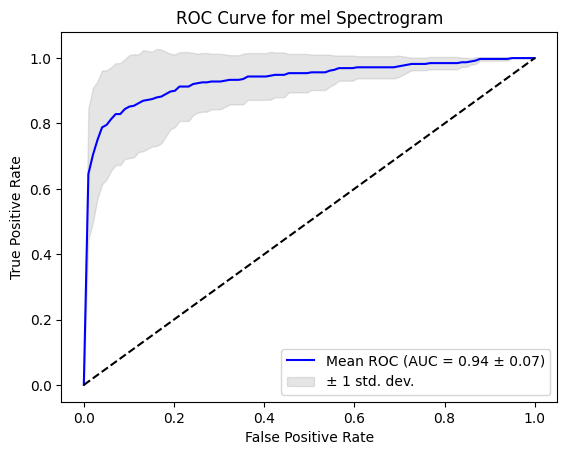


Mean and Std Dev of Performance Metrics for Spectrogram mel:
Fold                    3.000000
Accuracy               89.047619
F1 Score                0.890085
Precision               0.890029
Recall                  0.890476
Specificity             0.917974
Kappa                   0.764312
ROC AUC                 0.935080
Training Time (s)    1859.874422
Testing Time (s)       19.858722
dtype: float64
Fold                   1.581139
Accuracy               8.511697
F1 Score               0.085870
Precision              0.086354
Recall                 0.085117
Specificity            0.061993
Kappa                  0.185512
ROC AUC                0.073988
Training Time (s)    265.488710
Testing Time (s)       4.247128
dtype: float64


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED\mfcc'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model




Fold 1 - Speaker-Independent Evaluation
6/6 [==============================] - 11s 2s/step
Fold 1 Results: Accuracy=0.66, Precision=0.66, Recall=0.66, F1=0.62, Training Time=6918.05s, Testing Time=11.35s

Fold 2 - Speaker-Independent Evaluation
6/6 [==============================] - 9s 1s/step
Fold 2 Results: Accuracy=0.60, Precision=0.36, Recall=0.60, F1=0.45, Training Time=3151.50s, Testing Time=63.71s

Fold 3 - Speaker-Independent Evaluation
6/6 [==============================] - 7s 1s/step
Fold 3 Results: Accuracy=0.67, Precision=0.67, Recall=0.67, F1=0.67, Training Time=6354.04s, Testing Time=7.36s

Fold 4 - Speaker-Independent Evaluation
6/6 [==============================] - 8s 1s/step
Fold 4 Results: Accuracy=0.63, Precision=0.40, Recall=0.63, F1=0.49, Training Time=1401.24s, Testing Time=7.59s

Fold 5 - Speaker-Independent Evaluation
6/6 [==============================] - 7s 1s/step
Fold 5 Results: Accuracy=0.56, Precision=0.56, Recall=0.56, F1=0.56, Training Time=5546.26s, T

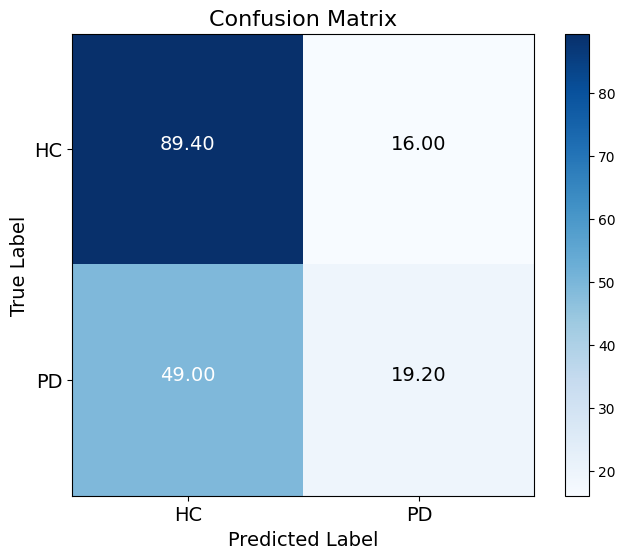

In [4]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED\chroma'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model




Fold 1 - Speaker-Independent Evaluation
7/7 [==============================] - 8s 1s/step
Fold 1 Results: Accuracy=0.81, Precision=0.81, Recall=0.81, F1=0.81, Training Time=11556.26s, Testing Time=8.52s

Fold 2 - Speaker-Independent Evaluation
7/7 [==============================] - 9s 1s/step
Fold 2 Results: Accuracy=0.72, Precision=0.73, Recall=0.72, F1=0.69, Training Time=2189.57s, Testing Time=9.32s

Fold 3 - Speaker-Independent Evaluation
7/7 [==============================] - 10s 1s/step
Fold 3 Results: Accuracy=0.78, Precision=0.77, Recall=0.78, F1=0.77, Training Time=1970.52s, Testing Time=9.65s

Fold 4 - Speaker-Independent Evaluation
7/7 [==============================] - 9s 1s/step
Fold 4 Results: Accuracy=0.68, Precision=0.75, Recall=0.68, F1=0.59, Training Time=1772.35s, Testing Time=9.12s

Fold 5 - Speaker-Independent Evaluation
7/7 [==============================] - 8s 1s/step
Fold 5 Results: Accuracy=0.69, Precision=0.69, Recall=0.69, F1=0.67, Training Time=2069.69s, Te

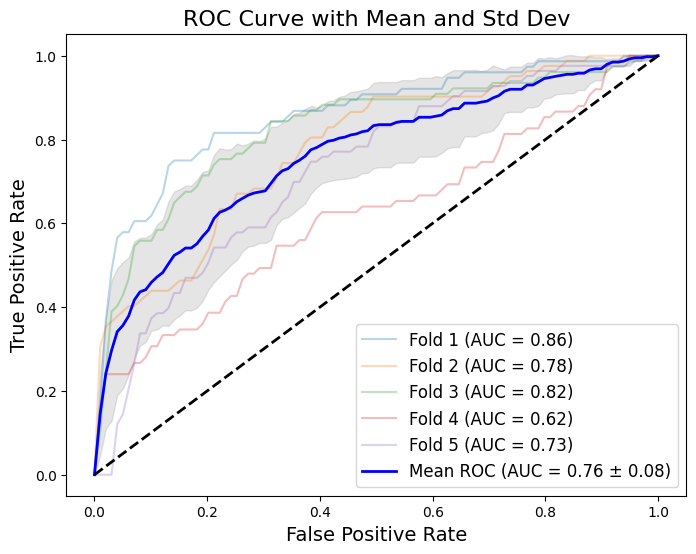

In [3]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED\cqt'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model



In [5]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)


Fold 1 - Speaker-Independent Evaluation
7/7 [==============================] - 8s 1s/step
Fold 1 Results: Accuracy=0.86, Precision=0.86, Recall=0.86, F1=0.86, Training Time=3919.86s, Testing Time=8.48s

Fold 2 - Speaker-Independent Evaluation
7/7 [==============================] - 17s 2s/step
Fold 2 Results: Accuracy=0.71, Precision=0.77, Recall=0.71, F1=0.66, Training Time=2979.06s, Testing Time=63.60s

Fold 3 - Speaker-Independent Evaluation
7/7 [==============================] - 26s 3s/step
Fold 3 Results: Accuracy=0.75, Precision=0.74, Recall=0.75, F1=0.74, Training Time=4787.92s, Testing Time=38.13s

Fold 4 - Speaker-Independent Evaluation
7/7 [==============================] - 20s 2s/step
Fold 4 Results: Accuracy=0.79, Precision=0.79, Recall=0.79, F1=0.79, Training Time=12654.68s, Testing Time=29.79s

Fold 5 - Speaker-Independent Evaluation
7/7 [==============================] - 20s 2s/step
Fold 5 Results: Accuracy=0.84, Precision=0.84, Recall=0.84, F1=0.84, Training Time=4994.8

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED\mel'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model




Fold 1 - Speaker-Independent Evaluation
7/7 [==============================] - 9s 1s/step
Fold 1 Results: Accuracy=0.77, Precision=0.80, Recall=0.77, F1=0.75, Training Time=8370.76s, Testing Time=11.36s

Fold 2 - Speaker-Independent Evaluation
7/7 [==============================] - 8s 1s/step
Fold 2 Results: Accuracy=0.66, Precision=0.70, Recall=0.66, F1=0.59, Training Time=2617.25s, Testing Time=7.73s

Fold 3 - Speaker-Independent Evaluation
7/7 [==============================] - 17s 2s/step
Fold 3 Results: Accuracy=0.76, Precision=0.76, Recall=0.76, F1=0.76, Training Time=5927.73s, Testing Time=21.94s

Fold 4 - Speaker-Independent Evaluation
7/7 [==============================] - 16s 2s/step
Fold 4 Results: Accuracy=0.80, Precision=0.79, Recall=0.80, F1=0.79, Training Time=11105.52s, Testing Time=44.87s

Fold 5 - Speaker-Independent Evaluation
7/7 [==============================] - 10s 1s/step
Fold 5 Results: Accuracy=0.77, Precision=0.77, Recall=0.77, F1=0.76, Training Time=8173.61

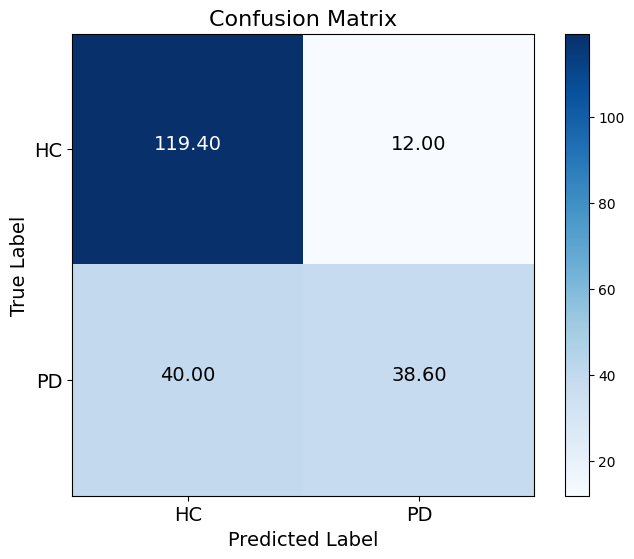

In [7]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED\stft'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model




Fold 1 - Speaker-Independent Evaluation
7/7 [==============================] - 10s 1s/step
Fold 1 Results: Accuracy=0.86, Precision=0.86, Recall=0.86, F1=0.86, Training Time=5709.81s, Testing Time=14.46s

Fold 2 - Speaker-Independent Evaluation
7/7 [==============================] - 9s 1s/step
Fold 2 Results: Accuracy=0.64, Precision=0.63, Recall=0.64, F1=0.62, Training Time=2164.92s, Testing Time=9.66s

Fold 3 - Speaker-Independent Evaluation
7/7 [==============================] - 9s 1s/step
Fold 3 Results: Accuracy=0.76, Precision=0.75, Recall=0.76, F1=0.75, Training Time=2623.33s, Testing Time=9.71s

Fold 4 - Speaker-Independent Evaluation
7/7 [==============================] - 13s 1s/step
Fold 4 Results: Accuracy=0.77, Precision=0.78, Recall=0.77, F1=0.75, Training Time=5186.66s, Testing Time=18.58s

Fold 5 - Speaker-Independent Evaluation
7/7 [==============================] - 15s 2s/step
Fold 5 Results: Accuracy=0.84, Precision=0.86, Recall=0.84, F1=0.83, Training Time=5779.34s,

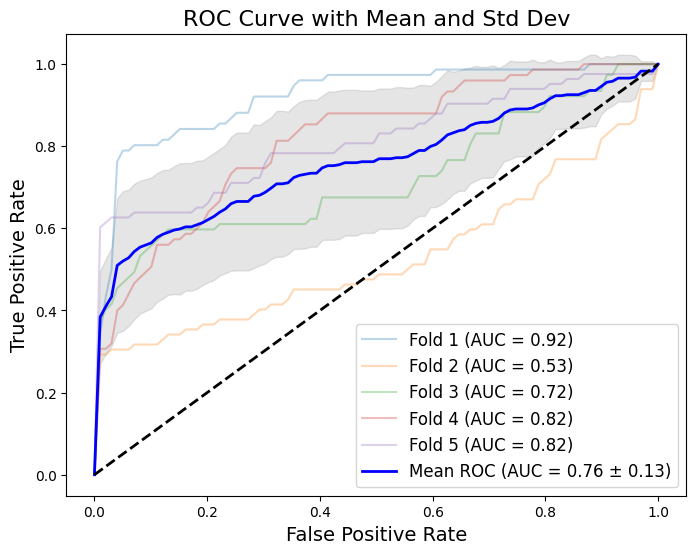

In [9]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)